In [1]:
import sys, os, glob, warnings, logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
def get_linescan_data(folder, sgRNA, time_d, n_edges=5):
    '''
    Read in linescan data and annotate with meta data
    
    Inputs:
    -------
        - folder: the folder that contains the linescan output csv file
        - sgRNA: which sgRNA was used for the treatment of this group
        - time_d: how many days after culture the samples were collected
        - n_edges: how many edges were quantified per sample
        
    Outputs:
        - df: pandas data frame with linescan data and annotation data
        
    '''
    
    linescan_files = glob.glob(os.path.join(folder, '*.txt'))

    if len(linescan_files) > 1:
        print('There are more than 1 output file in', folder)
        print('The newest one will be used.')
        linescan_files = sorted(linescan_files,
                                key = os.path.getmtime)
        
    df = pd.read_csv(linescan_files[-1])
    
    # annotate data
    assert len(df) % 5 == 0
    n_organoids = int(len(df) / 5)
    
    sample_ids = []
    for i in range(n_organoids):
        for j in range(n_edges):
            sample_ids.append(sgRNA + '_' + str(i+1))
    
    df['sample_id'] = sample_ids
    df['sgRNA'] = [sgRNA]*len(df)
    df['time_d'] = time_d
    df['groups'] = [sgRNA + '_' + str(time_d)]*len(df)
    
    return df

In [3]:
input_folder = '../data/220608-b1int-IF-E16/'
folders = glob.glob(os.path.join(input_folder, '*line-scan-output' + os.path.sep))

In [4]:
dfs = []
for folder in folders:
    if folder.endswith(os.path.sep):
        folder = folder[:-1]
    sgRNA = os.path.basename(folder).split('-')[2]
    time_d = 4
    dfs.append(get_linescan_data(folder, sgRNA, time_d, n_edges=5))

In [5]:
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)

In [6]:
df.tail()

,file_name,edge_category,id,b1int_AUC,b1int_peak_height,NLSmSL_cell_1,NLSmSL_cell_2,z_position,sample_id,sgRNA,time_d,groups
160,3,High_High,1,169.3868,22.7746,1715.1177,1000.0299,1,403_3,403,4,403_4
161,3,High_High,2,441.8480,40.0999,815.4210,1369.2257,1,403_3,403,4,403_4
162,3,High_High,3,-103.7256,30.4196,4095.0000,1843.2200,1,403_3,403,4,403_4
163,3,High_High,4,939.8510,68.4402,3008.0131,3025.0636,1,403_3,403,4,403_4
164,3,High_High,5,221.6023,25.0188,1400.8460,1428.5251,1,403_3,403,4,403_4


In [7]:
ctrl_average = df[df.sgRNA=='188'].b1int_peak_height.mean()
df['b1int_normed'] = df['b1int_peak_height'] / ctrl_average

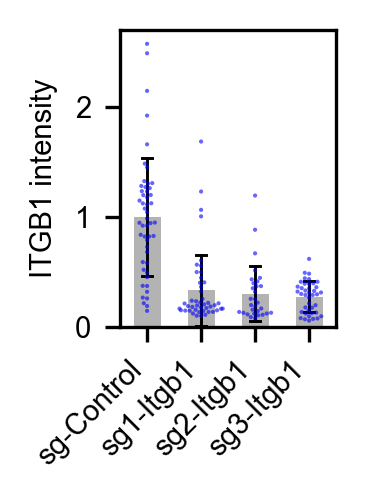

In [13]:
# Swarm plot of 4 categories

outputPrefix = '220608-IF-b1-integrin-E16-d4-bar-swarm'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width = 1.2
fig_height = 1.8

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax = fig.add_axes([0.35, 0.4, 0.6, 0.55])

ax = sns.swarmplot(x='groups', y='b1int_normed', data=df,
                   # hue='sample_id',
#                    palette={'1': 'red', '2': 'green', '3': 'blue', '4': yellow', '5': 'purple'},
                   color="blue",
                   size=1.0, alpha=.6)

ax = sns.barplot(x='groups', y='b1int_normed', data=df,
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci='sd')

# plt.ylim(0, 1.7)
# plt.ylim(0, 2.7)
# plt.yticks([0, 3, 6])

plt.xlabel(None)
# plt.ylabel(r"$\beta$1-integrin intensity")
plt.ylabel('ITGB1 intensity')

# make the bar width narrower
change_bar_width(ax, .5)

# rotate x tick labels
# x_labels = ax.get_xticklabels()
x_labels = ['sg-Control', 'sg1-Itgb1', 'sg2-Itgb1', 'sg3-Itgb1']
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

# ax.get_legend().remove()

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [10]:
tukeyTest(df.b1int_normed, df.groups)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 188_4  401_4  -0.6693  0.001 -0.8653 -0.4733   True
 188_4  402_4  -0.6995  0.001 -0.9198 -0.4793   True
 188_4  403_4   -0.729  0.001 -0.9313 -0.5267   True
 401_4  402_4  -0.0302    0.9  -0.255  0.1946  False
 401_4  403_4  -0.0597 0.8656  -0.267  0.1475  False
 402_4  403_4  -0.0295    0.9 -0.2598  0.2009  False
----------------------------------------------------
p values of all pair-wise tests:
 [0.001      0.001      0.001      0.9        0.86560462 0.9       ]


In [12]:
for i in df.sgRNA.unique():
    print(i, 'n =', len(df[df.sgRNA==i]))

188 n = 50
401 n = 45
402 n = 30
403 n = 40
